In [18]:
import os
import re
import matplotlib.pyplot as plt
from datetime import datetime
# Regex to capture timestamp and GPU leak list
line_pattern = re.compile(
    r"\[(?P<ts>[\d\-]+\s[\d:]+)\]\s+\[Leaked Memory\]\s+(?P<gpus>\[.*\])"
)

def parse_worker_log(filepath):
    """Parse a worker_x.err file, return timestamps and gpu_leaks dict."""
    timestamps = []
    gpu_leaks = {}  # {gpu_id: [values]}
    
    with open(filepath, "r") as f:
        for line in f:
            m = line_pattern.search(line)
            if not m:
                continue
            
            # Parse timestamp
            ts = datetime.strptime(m.group("ts"), "%Y-%m-%d %H:%M:%S")
            timestamps.append(ts)
            
            # Parse GPU leaks list safely with eval
            gpus = eval(m.group("gpus"))  # e.g. ['GPU 0: 105 MB', ...]
            for gpu_entry in gpus:
                gpu_id, mem_str = gpu_entry.split(":")
                gpu_id = gpu_id.strip()  # "GPU 0"
                mem = int(mem_str.strip().replace("MB", ""))
                
                if gpu_id not in gpu_leaks:
                    gpu_leaks[gpu_id] = []
                gpu_leaks[gpu_id].append(mem)
    
    return timestamps, gpu_leaks


def plot_all_workers(run_log_dir):
    worker_files = sorted(
        [f for f in os.listdir(run_log_dir) if f.startswith("worker_") and f.endswith(".err")]
    )
    
    num_workers = len(worker_files)
    fig, axes = plt.subplots(num_workers, 1, figsize=(10, 4 * num_workers), sharex=True)
    
    if num_workers == 1:
        axes = [axes]  # Ensure iterable
    
    for ax, worker_file in zip(axes, worker_files):
        filepath = os.path.join(run_log_dir, worker_file)
        timestamps, gpu_leaks = parse_worker_log(filepath)
        
        for gpu_id, mem_values in gpu_leaks.items():
            ax.plot(timestamps, mem_values, label=gpu_id, marker="o", markersize=3)
        
        ax.set_title(f"{worker_file}")
        ax.set_ylabel("Leaked Memory (MB)")
        ax.legend()
    
    axes[-1].set_xlabel("Time")
    plt.tight_layout()
    plt.show()

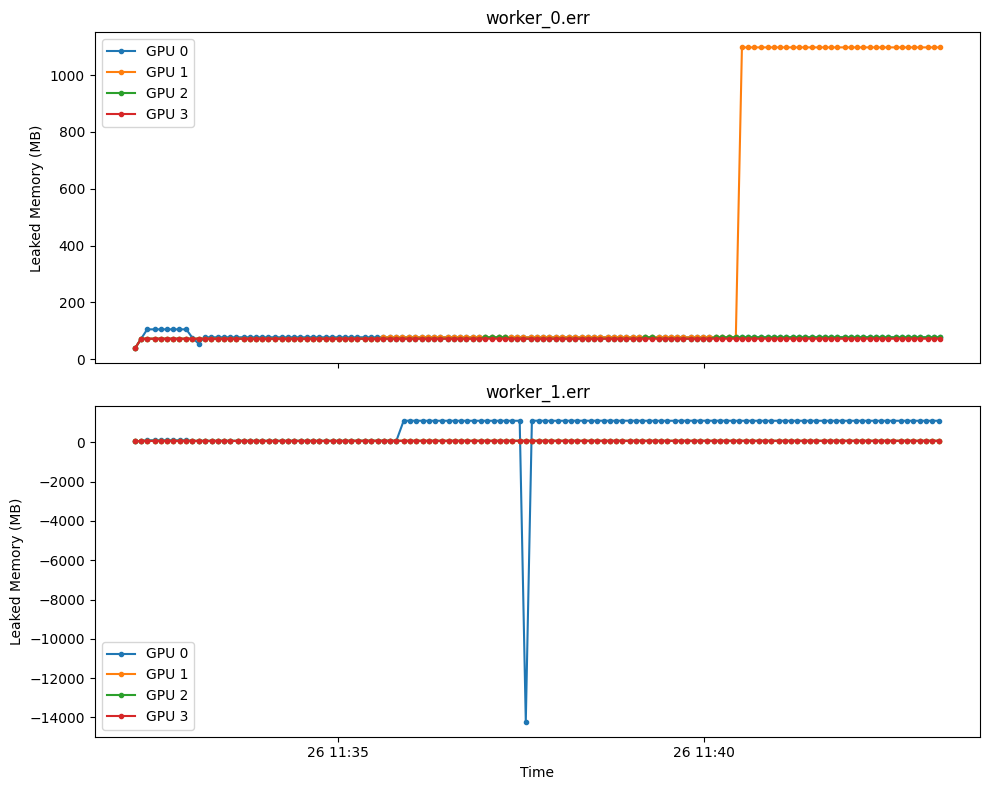

In [19]:
run_log_dir = "/mnt/network_drive/lrq/logs/logs_2025-08-26-11-31-11/run_0"
plot_all_workers(run_log_dir)